## 命名实体识别（NER）（也称为实体识别、实体分块和实体提取）
- 是信息提取的一个子任务，旨在将文本中的命名实体定位并分类为预先定义的类别，如人员、组织、位置、时间表达式、数量、货币值、百分比等。

#### 实现NER的方法有以下几种
- 统计的方法
- 机器学习
- 统计和机器学习
- LSTM
- CRF HMM
- LSTM + CRF
- Bert

- 命名实体识别的任务就是识别出待处理文本中三大类（实体类、时间类和数字类）、七小类（人名、机构名、地名、时间、日期、货币和百分比）命名实体。
- 主要识别人名PER，机构ORG和地点LOC： B表示开始的字节，I表示中间的字节，E表示最后的字节，S表示该实体是单字节

geo =区域实体(Geographical Entity)
org =组织(Organization)
per =人(Person)
gpe =地缘政治实体(Geopolitical Entity)
tim =时间指示器(Time indicator)
art =人工制品(Artifact)
eve =事件(Event)
nat =自然现象(Natural Phenomenon)

- Inside–outside–beginning(标记)

IOB(Inside–outside–beginning)是用于标记标志的通用标记格式。
I-标签前的前缀表示标签位于块内。
B-标签前的前缀表示标签是块的开头。
O标记表示标志不属于任何块(outside)。
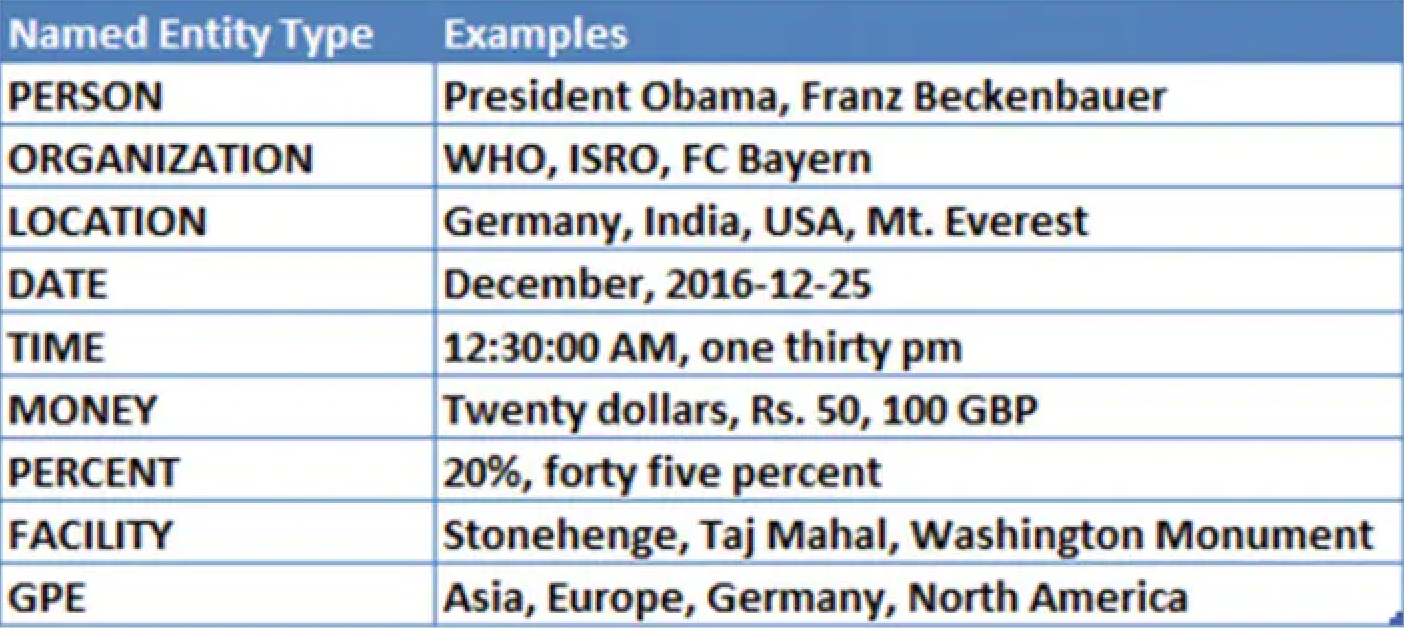

### 统计的方法及代码

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("./data/ner_dataset.csv",encoding='latin1')

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.shape

(1048575, 4)

In [5]:
data.isna().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [34]:
data["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [6]:
data[~data["Sentence #"].isna()]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
24,Sentence: 2,Families,NNS,O
54,Sentence: 3,They,PRP,O
68,Sentence: 4,Police,NNS,O
83,Sentence: 5,The,DT,O
...,...,...,...,...
1048501,Sentence: 47955,Indian,JJ,B-gpe
1048521,Sentence: 47956,Indian,JJ,B-gpe
1048545,Sentence: 47957,Two,CD,O
1048556,Sentence: 47958,They,PRP,O


In [7]:
data = data.fillna(method="ffill")

In [8]:
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [9]:
words = list(set(data["Word"].values))

In [10]:
n_words = len(words)

In [11]:
n_words

35178

In [12]:
len(data["Word"].values.tolist())

1048575

In [13]:
len(data["Word"].tolist())

1048575

In [14]:
class SentenceGetter(object):
    def __init__(self,data):
        self.data = data
        self.n_sent = 1
        self.empty = False
        
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent +=1
            return s["Word"].values.tolist(),s["POS"].values.tolist(),s["Tag"].values.tolist()
        except:
            self.empty =True
            return None,None,None

In [15]:
getter = SentenceGetter(data)

In [16]:
sent,pos,tag = getter.get_next()

In [17]:
sent

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [18]:
pos

['NNS',
 'IN',
 'NNS',
 'VBP',
 'VBN',
 'IN',
 'NNP',
 'TO',
 'VB',
 'DT',
 'NN',
 'IN',
 'NNP',
 'CC',
 'VB',
 'DT',
 'NN',
 'IN',
 'JJ',
 'NNS',
 'IN',
 'DT',
 'NN',
 '.']

In [19]:
tag

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [20]:
from sklearn.base import BaseEstimator,TransformerMixin

In [21]:
class MemoryTagger(BaseEstimator,TransformerMixin):
    def fit(self,X,y):
        voc ={}
        self.tags = []
        
        for w,t in zip(X,y):
            if t not in self.tags:
                self.tags.append(t)
            if w not in voc:
                voc[w] = {}
            if t not in voc[w]:
                voc[w][t] = 0
            voc[w][t] +=1
        self.memory = {}
        for k,d in voc.items():
#             print("*" * 100)
            self.memory[k] = max(d,key=d.get)
#             print(d.get)
#             print(self.memory[k])
#             print(self.memory)

    def predict(self,X,y=None):
        return [self.memory.get(x,"O") for x in X]        

# 存储形式： voc = {w1: {tag1:f1, tag2:f2...},w2: {tag1:f1, tag2:f2...},w3: {tag1:f1, tag2:f2...}...}

In [22]:
tagger = MemoryTagger()

In [23]:
tagger.fit(sent,tag)

In [24]:
print(tagger.predict(sent))

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [25]:
# 使用所有数据进行训练
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [26]:
words = data["Word"].values.tolist()
tags = data["Tag"].values.tolist()

In [27]:
pred = cross_val_predict(estimator=MemoryTagger(),X=words,y=tags,cv=5)

In [29]:
report = classification_report(y_pred=pred,y_true=tags)

In [30]:
report

'              precision    recall  f1-score   support\n\n       B-art       0.20      0.05      0.09       402\n       B-eve       0.54      0.25      0.34       308\n       B-geo       0.78      0.85      0.81     37644\n       B-gpe       0.94      0.93      0.94     15870\n       B-nat       0.42      0.28      0.33       201\n       B-org       0.67      0.49      0.56     20143\n       B-per       0.78      0.65      0.71     16990\n       B-tim       0.87      0.77      0.82     20333\n       I-art       0.04      0.01      0.01       297\n       I-eve       0.39      0.12      0.18       253\n       I-geo       0.73      0.58      0.65      7414\n       I-gpe       0.62      0.45      0.52       198\n       I-nat       0.00      0.00      0.00        51\n       I-org       0.69      0.53      0.60     16784\n       I-per       0.73      0.65      0.69     17251\n       I-tim       0.58      0.13      0.21      6528\n           O       0.97      0.99      0.98    887908\n\n    a

In [31]:
print(report,"\n")

              precision    recall  f1-score   support

       B-art       0.20      0.05      0.09       402
       B-eve       0.54      0.25      0.34       308
       B-geo       0.78      0.85      0.81     37644
       B-gpe       0.94      0.93      0.94     15870
       B-nat       0.42      0.28      0.33       201
       B-org       0.67      0.49      0.56     20143
       B-per       0.78      0.65      0.71     16990
       B-tim       0.87      0.77      0.82     20333
       I-art       0.04      0.01      0.01       297
       I-eve       0.39      0.12      0.18       253
       I-geo       0.73      0.58      0.65      7414
       I-gpe       0.62      0.45      0.52       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.69      0.53      0.60     16784
       I-per       0.73      0.65      0.69     17251
       I-tim       0.58      0.13      0.21      6528
           O       0.97      0.99      0.98    887908

    accuracy              

#### 统计和机器学习的方法

In [37]:
from sklearn.ensemble import RandomForestClassifier
def feature_map(word):
    return np.array([word.istitle(),word.islower(),word.isupper(),len(word),word.isdigit(),word.isalpha()])

In [38]:
words = [feature_map(w) for w in data["Word"].values.tolist()]

In [40]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words,y=tags,cv=5)

In [41]:
report = classification_report(y_pred=pred,y_true=tags)

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [42]:
print(report,"\n")

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.00      0.00      0.00       308
       B-geo       0.26      0.79      0.40     37644
       B-gpe       0.26      0.06      0.09     15870
       B-nat       0.00      0.00      0.00       201
       B-org       0.65      0.17      0.27     20143
       B-per       0.97      0.20      0.33     16990
       B-tim       0.29      0.32      0.30     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.00      0.00      0.00       253
       I-geo       0.00      0.00      0.00      7414
       I-gpe       0.00      0.00      0.00       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.36      0.03      0.06     16784
       I-per       0.47      0.02      0.04     17251
       I-tim       0.50      0.06      0.11      6528
           O       0.97      0.98      0.97    887908

    accuracy              

##### 加入前后单词的pos 和 tag的值

In [44]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [48]:
class FeatureTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.memory_tagger = MemoryTagger()
        self.tag_encoder, self.pos_encoder = LabelEncoder(),LabelEncoder()
    
    def fit(self,X,y):
        words = X["Word"].values.tolist()
        self.pos = X["POS"].values.tolist()
        tags = X["Tag"].values.tolist()
        self.memory_tagger.fit(words,tags)
        self.tag_encoder.fit(tags)
        self.pos_encoder.fit(self.pos)
        return self
    
    def transform(self,X,y=None):
        def pos_default(p):
            if p in self.pos:
                return self.pos_encoder.transform([p])[0]
            else:
                return -1
            
        pos = X["POS"].values.tolist()
        words = X["Word"].values.tolist()
        out = []
        
        for i in range(len(words)):
            w = words[i]
            p = pos[i]
            if i < len(words)-1:
                wp = self.tag_encoder.transform(self.memory_tagger.predict([words[i+1]]))[0]
                posp = pos_default(pos[i+1])
            else:
                wp = self.tag_encoder.transform(['O'])[0]
                posp = pos_default('.')
            
            if i >0:
                if words[i -1] != '.':
                    wm = self.tag_encoder.transform(self.memory_tagger.predict(words[i-1]))[0]
                    posm = pos_default(pos[i -1])
                else:
                    wm = self.tag_encoder.transform(['O'])[0]
                    posm = pos_default('.')
            else:
                posm = pos_default('.')
                wm = self.tag_encoder.transform(['O'])[0]
                
                
            out.append(np.array([
                w.istitle(),
                w.islower(),
                w.isupper(),
                len(w),
                w.isdigit(),
                w.isalpha(),
                self.tag_encoder.transform(self.memory_tagger.predict([w]))[0],
                pos_default(p),
                wp,
                wm,
                posp,
                posm]))
        return out

In [ ]:
featureTrans = FeatureTransformer()
featureTrans.fit(data,tags)
X_data = featureTrans.transform(data)